In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re
from google.colab import files

In [56]:
# Allow file upload
uploaded = files.upload()

Saving Volcano_day30.xlsx to Volcano_day30 (2).xlsx


In [57]:
# STEP 3: Load data
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name, sheet_name='Sheet1')

In [58]:
df


,Protein IDs,Alpha A53T_day_30_1,Alpha A53T_day_30_2,Alpha _day_30_1,Alpha _day_30_2
0,Q8T008;A8DY95;A1Z8A7,NaN,-2.285038,-0.646406,-1.390510
1,P12252-4;P12252-5;P12252;E2QD73;P12252-6;P1225...,NaN,-2.181804,-2.122366,-2.448194
2,Q9VIC9,-2.430820,-2.072483,NaN,-0.189960
3,Q7YU24;O18412,NaN,-1.980796,-0.537613,-0.992833
4,P08255,-0.627471,-1.930765,NaN,-3.020692
...,...,...,...,...,...
4427,Q9V771,2.640482,1.726395,0.571143,0.717912
4428,O97159;E1JI46;Q59E34;O16102,0.459851,-0.911750,-1.687056,-0.233006
4429,Q9VYQ8,0.093154,-1.275332,-2.385187,-1.118038
4430,Q9VWT1;Q8IQX8,2.648834,-1.484954,-1.156724,-1.075398


In [59]:
# Calculate mean for Alpha A53T_day_30 and Alpha _day_30 replicates
# Clean up column names by stripping whitespace
df.columns = df.columns.str.strip()

df['Alpha A53T_day_30_Mean'] = df[['Alpha A53T_day_30_1', 'Alpha A53T_day_30_2']].mean(axis=1)
df['Alpha _day_30_Mean'] = df[['Alpha _day_30_1', 'Alpha _day_30_2']].mean(axis=1)

In [60]:
# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['Alpha A53T_day_30_Mean'] / df['Alpha _day_30_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['Alpha A53T_day_30_Mean'] - df['Alpha _day_30_Mean'].replace(0, np.nan))

In [61]:
# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['Alpha A53T_day_30_1', 'Alpha A53T_day_30_2']].values,
    df[['Alpha _day_30_1', 'Alpha _day_30_2']].values,
    axis=1, nan_policy='omit'
)

/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [62]:
# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])


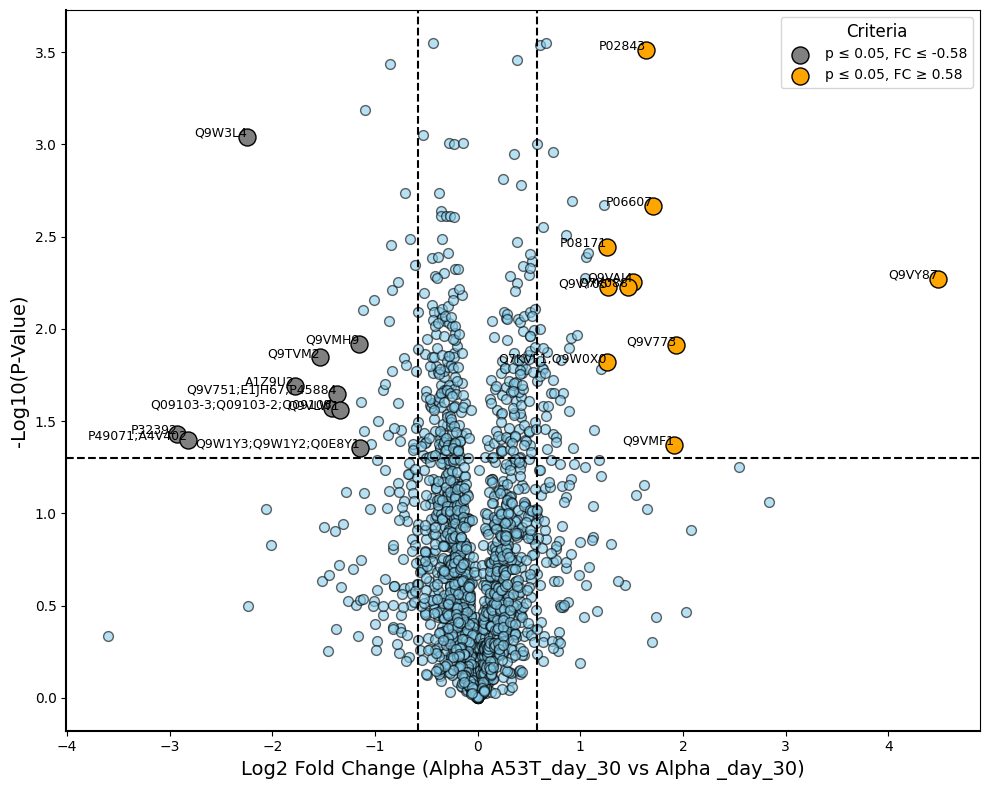

In [63]:
# Filter for statistically significant genes (P_Value < 0.05)
# Also drop any rows where P_Value or Log2_FC might be NaN to ensure clean selection
significant_and_clean_genes = df.dropna(subset=['P_Value', 'Log2_FC'])
significant_and_clean_genes = significant_and_clean_genes[significant_and_clean_genes['P_Value'] < 0.05]

# Select top 10 down-regulated genes from the significant set
down_regulated = significant_and_clean_genes.nsmallest(10, 'Log2_FC')

# Select top 10 up-regulated genes from the significant set
up_regulated = significant_and_clean_genes.nlargest(10, 'Log2_FC')

# Concatenate the top down and up-regulated genes
top_genes = pd.concat([down_regulated, up_regulated])


# Separate significant genes for coloring
left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]

# Explicitly remove NaNs from right_candidates before plotting
right_candidates = right_candidates.dropna(subset=['Log2_FC', 'MinusLog10_P'])


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='grey', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='orange', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58')

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Protein IDs'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (Alpha A53T_day_30 vs Alpha _day_30)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
png_path = "Volcano_30.png"
pdf_path = "Volcano-30.pdf"
plt.savefig(png_path, dpi=600, format="png")
plt.savefig(pdf_path, format="pdf")
plt.show()


In [64]:
print("Top 10 Down-Regulated Genes (Mean Values):")
display(down_regulated[['Protein IDs', 'Alpha A53T_day_30_Mean', 'Alpha _day_30_Mean', 'Log2_FC', 'P_Value']])

print("\nTop 10 Up-Regulated Genes (Mean Values):")
display(up_regulated[['Protein IDs', 'Alpha A53T_day_30_Mean', 'Alpha _day_30_Mean', 'Log2_FC', 'P_Value']])


Top 10 Down-Regulated Genes (Mean Values):


,Protein IDs,Alpha A53T_day_30_Mean,Alpha _day_30_Mean,Log2_FC,P_Value
2561,P32392,-1.806126,1.122076,-2.928202,0.037061
2560,P49071;A4V402,-1.555835,1.267536,-2.823371,0.040199
2565,Q9W3L4,-2.264499,-0.019601,-2.244898,0.000910
18,A1Z9U2,-1.517296,0.261813,-1.779109,0.020500
2573,Q9TVM2,-2.742323,-1.204067,-1.538256,0.014221
2575,Q09103-3;Q09103-2;Q09103,-4.274871,-2.856897,-1.417974,0.026965
2593,Q9V751;E1JH67;P45884,-3.910535,-2.535174,-1.375360,0.022401
2590,Q9VLW1,-2.249531,-0.905870,-1.343661,0.027377
2586,Q9VMH9,-0.280910,0.874186,-1.155096,0.012047
2633,Q9W1Y3;Q9W1Y2;Q0E8Y1,-2.382326,-1.239116,-1.143209,0.044035



Top 10 Up-Regulated Genes (Mean Values):


,Protein IDs,Alpha A53T_day_30_Mean,Alpha _day_30_Mean,Log2_FC,P_Value
4431,Q9VY87,2.476901,-2.012312,4.489212,0.005329
4426,Q9V773,2.021302,0.087032,1.934270,0.012232
166,Q9VMF1,1.142544,-0.774444,1.916988,0.042418
4423,P06607,0.829962,-0.878641,1.708603,0.002162
4418,P02843,1.919685,0.276481,1.643204,0.000308
4416,Q9VAJ4,2.165667,0.655933,1.509734,0.005586
4420,Q7K088,1.803361,0.338887,1.464474,0.005923
4410,Q9VY05,-0.080338,-1.348477,1.268139,0.005955
4409,P08171,0.302260,-0.960673,1.262933,0.003574
4411,Q7KVF1;Q9W0X0,1.347688,0.092243,1.255445,0.015125


In [65]:
# Export down-regulated genes to CSV
down_regulated.to_csv('down_regulated_genes.csv', index=False)
print("Down-regulated genes exported to 'down_regulated_genes.csv'")

# Export up-regulated genes to CSV
up_regulated.to_csv('up_regulated_genes.csv', index=False)
print("Up-regulated genes exported to 'up_regulated_genes.csv'")

Down-regulated genes exported to 'down_regulated_genes.csv'
Up-regulated genes exported to 'up_regulated_genes.csv'


/tmp/ipython-input-2047371926.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'weight': 'bold'})


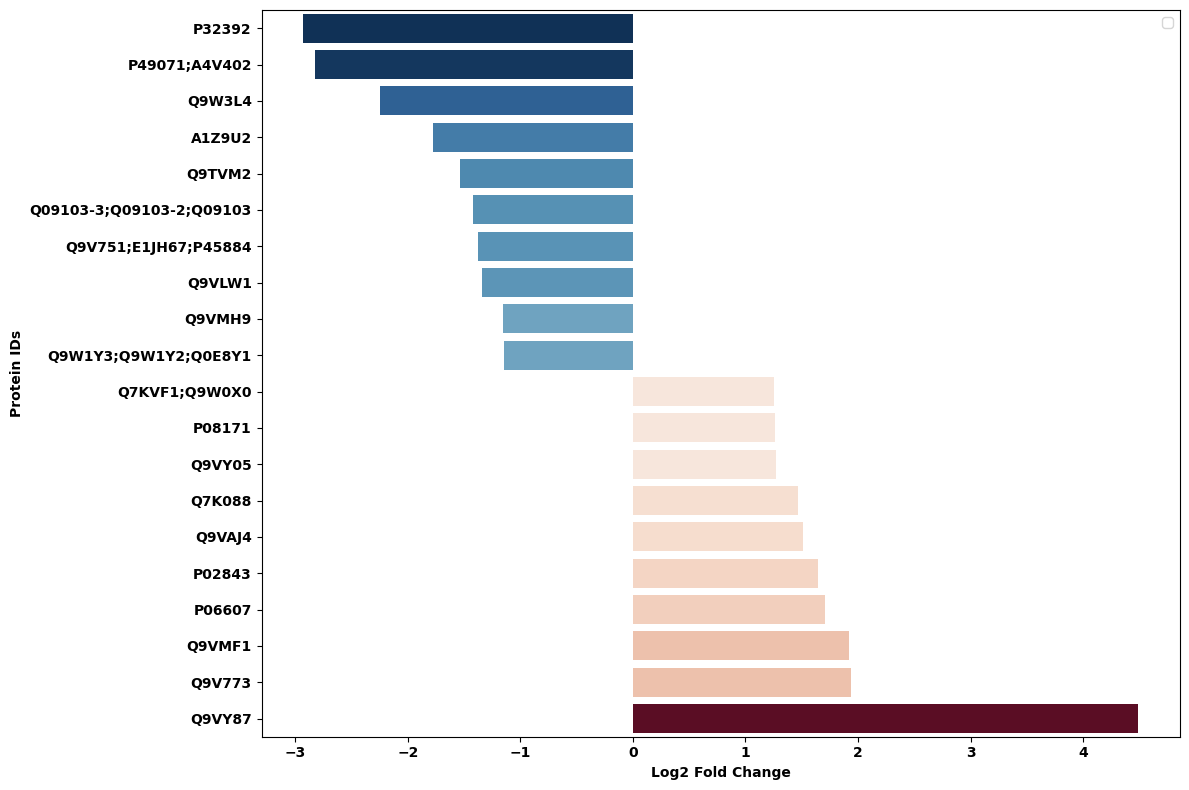

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine up-regulated and down-regulated genes for a single plot
combined_genes = pd.concat([up_regulated, down_regulated ]).sort_values('Log2_FC', ascending=True)

# Create a bar chart for combined up and down-regulated genes
plt.figure(figsize=(12, 8))
sns.barplot(x='Log2_FC', y='Protein IDs', data=combined_genes, palette='RdBu_r', hue='Log2_FC', legend=False)
plt.xlabel('Log2 Fold Change', fontweight='bold')
plt.ylabel('Protein IDs', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.tight_layout()
png_path = "Volcano_30_list.png"
pdf_path = "Volcano-30_list.pdf"
plt.savefig(png_path, dpi=600, format="png")
plt.savefig(pdf_path, format="pdf")
plt.show()